# GAUSS Data

This notebook uses a specialized dataset that at this time cannot be shared externally due to liscencing. If running this series of notebooks on your own, please skip this notebook, and use the output from `08_CTD` as input to `10_Semmantic_Compression`.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

from data_tools import combine_nodes_and_edges
from data_tools.wiki import get_curi_xrefs
from data_tools.plotting import venn2_pretty, count_plot_h
from data_tools.df_processing import expand_col_on_char, expand_df_on_col, expand_split_col, combine_group_cols_on_char

/opt/mmayers/software/anaconda3/envs/ml/lib/python3.6/site-packages/data_tools/df_processing.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
df = pd.read_csv('../0_data/external/gaussWithIdentifierMatch.tsv', sep='\t')

In [3]:
df.head(2)

,DB,ICD9code,PID,cases,category,controls,gaussName,geneSet,pval,selectedGenes
0,DOID:11329,136.0,GO:0005549,205.0,infectious diseases,408429.0,Other infectious and parasitic diseases,GO_ODORANT_BINDING,0.004,"OR5H6,OR5K3,OR5K4,OR5L2,OR5J2,OR8U1,OR8A1,OR11..."
1,DOID:3277,164.0,GO:0005549,57.0,neoplasms,406226.0,Cancer of intrathoracic organs,GO_ODORANT_BINDING,0.020,"OR5B2,OR8J3,OR5H1,OR5H14,OR5D13,OR8H3,OR5B12,O..."


In [4]:
df['dis_source'] = df['DB'].apply(lambda s: s.split(':')[0])

In [5]:
df['gset_source'] = df['PID'].apply(lambda s: s.split(':')[0])

In [6]:
nodes = pd.read_csv('../2_pipeline/08_CTD/out/nodes.csv', dtype=str)
edges = pd.read_csv('../2_pipeline/08_CTD/out/edges.csv', dtype=str)

In [7]:
combo = combine_nodes_and_edges(nodes, edges)

# Map Disease and get Gene to disease links

### Mapping To the Network

In [8]:
umls_to_nw = get_curi_xrefs(nodes, 'UMLS')
mesh_to_nw = get_curi_xrefs(nodes, 'MESH')
doid_to_nw = get_curi_xrefs(nodes, 'DOID')

In [9]:
umls_to_nw.head(2)

,id,xrefs
38215,DOID:0001816,UMLS:C0018923
38216,DOID:0001816,UMLS:C0854893


In [10]:
nw_ids = nodes['id'].tolist()

In [11]:
umls_mrg = df.merge(umls_to_nw.rename(columns={'xrefs': 'DB'}), on='DB', how='inner')
mesh_mrg = df.merge(mesh_to_nw.rename(columns={'xrefs': 'DB'}), on='DB', how='inner')
doid_mrg = df.merge(doid_to_nw.rename(columns={'xrefs': 'DB'}), on='DB', how='inner')
direct_map = df.query('DB in @nw_ids').copy()
direct_map['id'] = direct_map['DB']

dis_mapped = pd.concat([umls_mrg, mesh_mrg, doid_mrg, direct_map]).drop_duplicates()
dis_mapped = dis_mapped.rename(columns={'id': 'dis_id'})

In [12]:
len(dis_mapped)

37464

### Getting Disease to Gene Links

In [13]:
sym_xref = get_curi_xrefs(nodes, 'SYM')

In [14]:
dis_exp = expand_col_on_char(dis_mapped, 'selectedGenes', ',')
dis_exp['selectedGenes'] = 'SYM:' + dis_exp['selectedGenes']
dis_exp = dis_exp.merge(sym_xref.rename(columns={'id': 'gene_id', 'xrefs': 'selectedGenes'}), how='left')

In [15]:
dis_exp['gene_id'].count() / len(dis_exp)

0.9628591740368879

In [16]:
dis_gene = dis_exp.dropna(subset=['dis_id', 'gene_id'])[['dis_id', 'gene_id']].drop_duplicates()

len(dis_gene)

129303

In [17]:
gene_dis_tups = dis_gene[['gene_id', 'dis_id']].dropna().apply(tuple, axis=1)

### Compare these mappings to those in NW

In [18]:
gene_ids = dis_gene['gene_id'].dropna().unique()
g_lbl = nodes.query('id in @gene_ids')['label'].unique()

dis_ids = dis_gene['dis_id'].unique()
dis_lbl = nodes.query('id in @dis_ids')['label'].unique()

In [19]:
nw_gd_e_tup = combo.query('start_label in @g_lbl and end_label in @dis_lbl')[['start_id', 'end_id']].apply(tuple, axis=1)

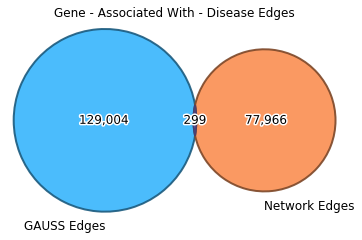

In [20]:
v = venn2_pretty([set(gene_dis_tups), set(nw_gd_e_tup)], ['GAUSS Edges' ,'Network Edges'])
plt.title('Gene - Associated With - Disease Edges');

# Map Genesets to network and get Gene to GeneSet Edges

### Map the genesets to the network

In [21]:
df['gset_source'].value_counts()

GO               55087
KEGG              2031
R-HSA-379726        94
R-HSA-381753        85
R-HSA-140342        79
R-HSA-977606        75
R-HSA-933542        67
R-HSA-879415        66
R-HSA-180689        64
R-HSA-9013694       64
R-HSA-435354        64
R-HSA-1236977       63
R-HSA-379724        63
R-HSA-6783310       61
R-HSA-918233        59
R-HSA-622323        59
R-HSA-1236975       59
R-HSA-166663        59
R-HSA-1483191       58
R-HSA-1236974       57
R-HSA-375281        55
R-HSA-159854        55
R-HSA-549132        55
R-HSA-983189        55
R-HSA-629594        54
R-HSA-1433559       54
R-HSA-264870        54
R-HSA-2142845       53
R-HSA-382556        52
R-HSA-1912420       51
                 ...  
R-HSA-975138         9
R-HSA-912694         9
R-HSA-168249         9
R-HSA-193648         8
R-HSA-157118         8
R-HSA-162906         8
R-HSA-163210         8
R-HSA-71406          8
R-HSA-69481          8
R-HSA-975110         8
R-HSA-112043         7
R-HSA-416476         7
R-HSA-10958

In [22]:
react_idx = df.query('gset_source not in {}'.format(['GO', 'KEGG'])).index

df.loc[react_idx, 'gset_source'] = 'REACT'
df.loc[react_idx, 'PID'] = 'REACT:' + df.loc[react_idx, 'PID']

df['gset_source'].value_counts()

GO       55087
REACT     5815
KEGG      2031
Name: gset_source, dtype: int64

In [23]:
go_to_nw = get_curi_xrefs(nodes, 'GO')
kegg_to_nw = get_curi_xrefs(nodes, 'KEGG')
react_to_nw = get_curi_xrefs(nodes, 'REACT')

In [24]:
nw_kegg_ids = nodes[nodes['id'].str.startswith('KEGG:')]['id'].unique()

In [25]:
nw_kegg_ids[:10]

array(['KEGG:63515', 'KEGG:C03030', 'KEGG:C03365', 'KEGG:C10890',
       'KEGG:D02152', 'KEGG:D03111', 'KEGG:D03420', 'KEGG:D04136',
       'KEGG:D05061', 'KEGG:D07744'], dtype=object)

In [26]:
df.query('gset_source == "KEGG"')['PID'].values[:10]

array(['KEGG:04740', 'KEGG:00310', 'KEGG:04512', 'KEGG:04740',
       'KEGG:04610', 'KEGG:00310', 'KEGG:05200', 'KEGG:05222',
       'KEGG:04740', 'KEGG:04742'], dtype=object)

There appears to be a species tag that is missing from this data source.  We will add it with a custom function

In [27]:
def add_kegg_hsa(kegg_id):
    pref, kid = kegg_id.split(':')
    
    try:
        # If it is an integer, needs hsa, otherwise keep as is
        int_kid = int(kid)
    except:
        return kegg_id
    
    return 'KEGG:hsa{}'.format(kid)

In [28]:
kegg_idx = df.query('gset_source == "KEGG"').index

df.loc[kegg_idx, 'PID'] = df.loc[kegg_idx, 'PID'].apply(add_kegg_hsa)
df.query('gset_source == "KEGG"')['PID'].values[:10]

array(['KEGG:hsa04740', 'KEGG:hsa00310', 'KEGG:hsa04512', 'KEGG:hsa04740',
       'KEGG:hsa04610', 'KEGG:hsa00310', 'KEGG:hsa05200', 'KEGG:hsa05222',
       'KEGG:hsa04740', 'KEGG:hsa04742'], dtype=object)

In [29]:
len(set(nw_kegg_ids) & set(df.query('gset_source == "KEGG"')['PID'])), df.query('gset_source == "KEGG"')['PID'].nunique()

(77, 78)

77 out of 78. Doing well now. So lets proceed with the merge

In [30]:
go_mrg = df.merge(go_to_nw.rename(columns={'xrefs': 'PID'}), on='PID', how='inner')
kegg_mrg = df.merge(kegg_to_nw.rename(columns={'xrefs': 'PID'}), on='PID', how='inner')
react_mrg = df.merge(react_to_nw.rename(columns={'xrefs': 'PID'}), on='PID', how='inner')
direct_map = df.query('PID in @nw_ids').copy()
direct_map['id'] = direct_map['PID']

gset_mapped = pd.concat([go_mrg, kegg_mrg, react_mrg, direct_map], sort=False).drop_duplicates()
gset_mapped = gset_mapped.rename(columns={'id': 'gset_id'})
len(gset_mapped)

59541

### Read in Gene to GeneSet information

In [31]:
g_gs = pd.read_csv('../0_data/external/genesWithinGeneset.tsv', sep='\t')
g_gs.head(2)

,pathName,geneSetList
0,GO_3_5_DNA_HELICASE_ACTIVITY,"[""FBXO18"",""RECQL5"",""GINS1"",""ERCC3"",""ASCC3"",""GI..."
1,GO_5_3_EXONUCLEASE_ACTIVITY,"[""XRN2"",""DCLRE1C"",""POLN"",""CPSF3"",""EXO1"",""DCLRE..."


In [32]:
g_gs['geneSetList'] = g_gs['geneSetList'].apply(eval)

In [33]:
g_gs['n_genes'] = g_gs['geneSetList'].apply(len)
g_gs.query('n_genes > 1000').sample(2)

,pathName,geneSetList,n_genes
1667,GO_PROTEIN_LOCALIZATION,"[AKT2, INPP5K, TIMM10, WRAP53, RHOU, RAB3GAP2,...",1805
200,GO_CELLULAR_CATABOLIC_PROCESS,"[UBE2G2, HADHB, PLA2G4A, RNF20, CCBL1, CPN1, T...",1322


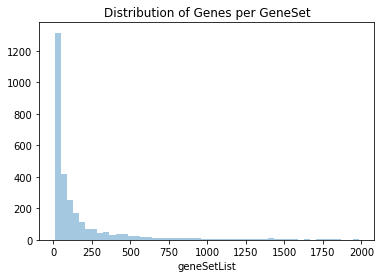

In [34]:
sns.distplot(g_gs['geneSetList'].apply(len), kde=False)
plt.title('Distribution of Genes per GeneSet');

In [35]:
g_gs = expand_df_on_col(g_gs, 'geneSetList')
g_gs.head(2)

,pathName,geneSetList,n_genes
0,GO_3_5_DNA_HELICASE_ACTIVITY,FBXO18,12
1,GO_3_5_DNA_HELICASE_ACTIVITY,RECQL5,12


In [36]:
g_gs['geneSetList'] = 'SYM:' + g_gs['geneSetList']
g_gs = g_gs.merge(sym_xref.rename(columns={'id': 'gene_id', 'xrefs': 'geneSetList'}), how='left', on='geneSetList')
g_gs.head(2)

,pathName,geneSetList,n_genes,gene_id
0,GO_3_5_DNA_HELICASE_ACTIVITY,SYM:FBXO18,12,NaN
1,GO_3_5_DNA_HELICASE_ACTIVITY,SYM:RECQL5,12,NCBIGene:9400


In [37]:
g_gs.count() / len(g_gs)

pathName       1.00000
geneSetList    1.00000
n_genes        1.00000
gene_id        0.95046
dtype: float64

In [38]:
gset_exp = gset_mapped.merge(g_gs.rename(columns={'pathName': 'geneSet'}), how='left', on='geneSet')
gset_exp.head(2)

,DB,ICD9code,PID,cases,category,controls,gaussName,geneSet,pval,selectedGenes,dis_source,gset_source,gset_id,geneSetList,n_genes,gene_id
0,DOID:11329,136.0,GO:0005549,205.0,infectious diseases,408429.0,Other infectious and parasitic diseases,GO_ODORANT_BINDING,0.004,"OR5H6,OR5K3,OR5K4,OR5L2,OR5J2,OR8U1,OR8A1,OR11...",DOID,GO,GO:0005549,SYM:OR5D16,92,NCBIGene:390144
1,DOID:11329,136.0,GO:0005549,205.0,infectious diseases,408429.0,Other infectious and parasitic diseases,GO_ODORANT_BINDING,0.004,"OR5H6,OR5K3,OR5K4,OR5L2,OR5J2,OR8U1,OR8A1,OR11...",DOID,GO,GO:0005549,SYM:OR9K2,92,NCBIGene:441639


In [39]:
gene_gset = gset_exp.dropna(subset=['gene_id', 'gset_id']).drop_duplicates(subset=['gene_id', 'gset_id'])
len(gene_gset)

424895

### Compare with network

In [40]:
gene_gset_tups = gene_gset[['gene_id', 'gset_id']].apply(tuple, axis=1)

In [41]:
mapped_gset = gene_gset['gset_id'].unique()

gset_lbl = nodes.query('id in @mapped_gset')['label'].unique().tolist()
nw_ggs_e_tup = combo.query('end_label in @gset_lbl and start_label in @g_lbl')[['start_id', 'end_id']].apply(tuple, axis=1)

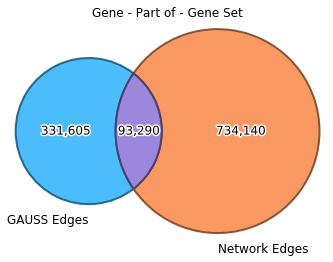

In [42]:
v = venn2_pretty([set(gene_gset_tups), set(nw_ggs_e_tup)], ['GAUSS Edges' ,'Network Edges'])
plt.title('Gene - Part of - Gene Set');

In [43]:
gene_kegg_tups = gene_gset.query('gset_source == "KEGG"')[['gene_id', 'gset_id']].apply(tuple, axis=1)

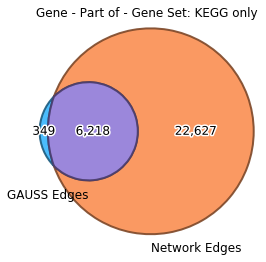

In [44]:
v = venn2_pretty([set(gene_kegg_tups), set([t for t in nw_ggs_e_tup if t[1].startswith('KEGG')])], ['GAUSS Edges' ,'Network Edges'])
plt.title('Gene - Part of - Gene Set: KEGG only');

In [45]:
gene_go_tups = gene_gset.query('gset_source == "GO"')[['gene_id', 'gset_id']].apply(tuple, axis=1)

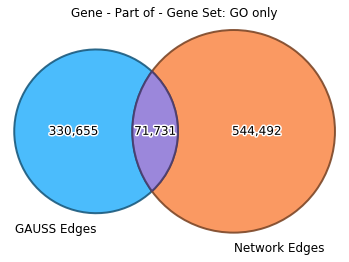

In [46]:
v = venn2_pretty([set(gene_go_tups), set([t for t in nw_ggs_e_tup if t[1].startswith('GO')])], ['GAUSS Edges' ,'Network Edges'])
plt.title('Gene - Part of - Gene Set: GO only');

In [47]:
gene_react_tups = gene_gset.query('gset_source == "REACT"')[['gene_id', 'gset_id']].apply(tuple, axis=1)

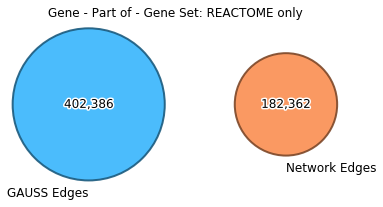

In [48]:
v = venn2_pretty([set(gene_go_tups), set([t for t in nw_ggs_e_tup if t[1].startswith('REACT')])], ['GAUSS Edges' ,'Network Edges'])
plt.title('Gene - Part of - Gene Set: REACTOME only');

Weird... did they do punning that we haven't done? (SOURCE OF THIS DATA IS MSIGDB)

# Map GeneSet to Disease to the Network

In [49]:
d_to_nw = dis_mapped[['dis_id', 'DB']].drop_duplicates().dropna()

In [50]:
gs_to_nw = gset_mapped[['gset_id', 'PID']].drop_duplicates().dropna()

In [51]:
gset_to_dis = df.merge(d_to_nw, on='DB', how='inner')
gset_to_dis = gset_to_dis.merge(gs_to_nw, on='PID', how='inner').drop_duplicates()

len(gset_to_dis)

37421

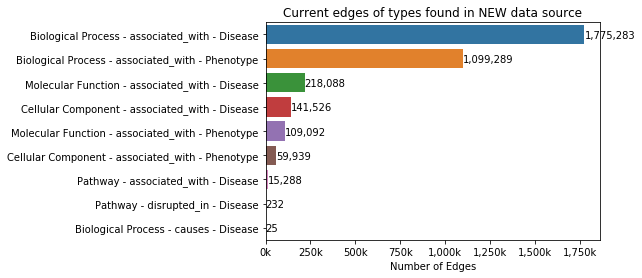

In [52]:
nw_es = combo.query('start_label in @gset_lbl and end_label in @dis_lbl')

res = (nw_es['start_label'] + ' - ' + nw_es['type'] + ' - ' + nw_es['end_label']).value_counts()

fmt_func = lambda x, y: '{:,}k'.format(int(x // 1000))

fig, ax = plt.subplots()
count_plot_h(res)
plt.title('Current edges of types found in NEW data source')
plt.xlabel('Number of Edges')
ax.xaxis.set_major_formatter(plt.FuncFormatter(fmt_func));

In [53]:
gset_to_dis_tup = gset_to_dis[['gset_id', 'dis_id']].drop_duplicates().apply(tuple, axis=1)

In [54]:
%%time
nw_gsd_e_tup = nw_es[['start_id', 'end_id']].apply(tuple, axis=1)

CPU times: user 1min 6s, sys: 388 ms, total: 1min 7s
Wall time: 1min 7s


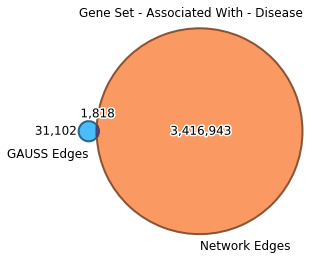

In [55]:
v = venn2_pretty([set(gset_to_dis_tup), set(nw_gsd_e_tup)], ['GAUSS Edges' ,'Network Edges'])
lbl = v.get_label_by_id('11')
x, y = lbl.get_position()
lbl.set_position((x, y+.3))

lbl = v.get_label_by_id('10')
x, y = lbl.get_position()
lbl.set_position((x-.55, y))
plt.title('Gene Set - Associated With - Disease');

In [56]:
overlap_e_tups = combo.query('start_id in @mapped_gset and end_id in @dis_ids')[['start_id', 'end_id']].apply(tuple, axis=1)

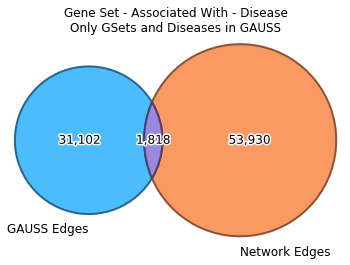

In [57]:
v = venn2_pretty([set(gset_to_dis_tup), set(overlap_e_tups)], ['GAUSS Edges' ,'Network Edges'])
plt.title('Gene Set - Associated With - Disease\nOnly GSets and Diseases in GAUSS');

In [58]:
nw_gauss_dis_deg = combo.query('type == "associated_with" and end_id in @dis_ids')['end_id'].value_counts()
nw_gauss_pw_deg = combo.query('type == "associated_with" and start_id in @mapped_gset')['start_id'].value_counts()

In [59]:
nw_all_dis_deg = combo.query('type == "associated_with" and end_label in @dis_lbl')['end_id'].value_counts()
nw_all_pw_deg = combo.query('type == "associated_with" and start_label in @gset_lbl')['start_id'].value_counts()

In [60]:
nw_other_dis_deg = combo.query('type == "associated_with" and end_label in @dis_lbl and end_id not in @dis_ids')['end_id'].value_counts()
nw_other_pw_deg = combo.query('type == "associated_with" and start_label in @gset_lbl and start_id not in @mapped_gset')['start_id'].value_counts()

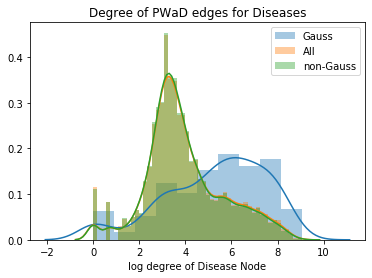

In [61]:
sns.distplot(np.log(nw_gauss_dis_deg), label = 'Gauss')
sns.distplot(np.log(nw_all_dis_deg), label = 'All')
sns.distplot(np.log(nw_other_dis_deg), label = 'non-Gauss')
plt.legend()
plt.xlabel('log degree of Disease Node')
plt.title('Degree of PWaD edges for Diseases');

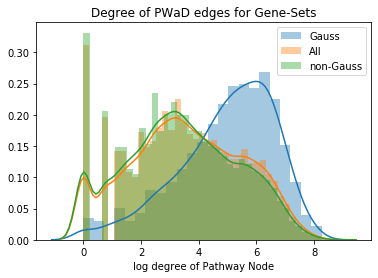

In [62]:
sns.distplot(np.log(nw_gauss_pw_deg), label = 'Gauss')
sns.distplot(np.log(nw_all_pw_deg), label = 'All')
sns.distplot(np.log(nw_other_pw_deg), label = 'non-Gauss')
plt.legend()
plt.xlabel('log degree of Pathway Node')
plt.title('Degree of PWaD edges for Gene-Sets');

In [63]:
dis_no_edge_in_nw = set(dis_ids) - set(nw_gauss_dis_deg.index)
pw_no_edge_in_nw = set(mapped_gset) - set(nw_gauss_pw_deg.index)

print('Diseases with Dis-Gset assoc: {:,}'.format(len(dis_ids) - len(dis_no_edge_in_nw)))
print('Diseases without Dis-Gset assoc: {:,}'.format(len(dis_no_edge_in_nw)))
print('% of new Diseases in GAUSS Dataset: {:1.2%}'.format(len(dis_no_edge_in_nw) / len(dis_ids)))
print('# Assoc. to diseases with no previous Assoc: {:,}'.format(len(gset_to_dis.query('dis_id in @dis_no_edge_in_nw'))))
print('% of total GAUSS assoc to Disease with no previous assoc: {:1.2%}'.format(len(gset_to_dis.query('dis_id in @dis_no_edge_in_nw')) / len(gset_to_dis)))

print('\n')
print('Gsets with previous Dis-Gset assoc: {:,}'.format(len(mapped_gset) - len(pw_no_edge_in_nw)))
print('Gsets without previous Dis-Gset assoc: {:,}'.format(len(pw_no_edge_in_nw)))
print('% of new Gsets in GAUSS Dataset: {:1.2%}'.format(len(pw_no_edge_in_nw) / len(mapped_gset)))
print('# Assoc to Gsets with no previous assoc: {:,}'.format(len(gset_to_dis.query('gset_id in @pw_no_edge_in_nw'))))
print('% of total GAUSS assoc to Gsets with no previous assoc: {:1.2%}'.format(len(gset_to_dis.query('gset_id in @pw_no_edge_in_nw')) / len(gset_to_dis)))


print('\n')
print('# Assoc between gsets and diseases both with no previous assoc: {:,}'.format(len(gset_to_dis.query('dis_id in @dis_no_edge_in_nw and gset_id in @pw_no_edge_in_nw'))))
print('{:1.2%}'.format(len(gset_to_dis.query('dis_id in @dis_no_edge_in_nw and gset_id in @pw_no_edge_in_nw')) / len(gset_to_dis)))

Diseases with Dis-Gset assoc: 313
Diseases without Dis-Gset assoc: 138
% of new Diseases in GAUSS Dataset: 30.60%
# Assoc. to diseases with no previous Assoc: 7,365
% of total GAUSS assoc to Disease with no previous assoc: 19.68%


Gsets with previous Dis-Gset assoc: 1,955
Gsets without previous Dis-Gset assoc: 624
% of new Gsets in GAUSS Dataset: 24.20%
# Assoc to Gsets with no previous assoc: 9,788
% of total GAUSS assoc to Gsets with no previous assoc: 26.16%


# Assoc between gsets and diseases both with no previous assoc: 1,992
5.32%


In [64]:
(nw_gauss_dis_deg <= 10).sum(), (nw_gauss_dis_deg > 10).sum() 

(29, 284)

In [65]:
(nw_gauss_pw_deg <= 10).sum(), (nw_gauss_pw_deg > 10).sum()

(157, 1798)

Just as a quick summary, Gauss had 431 Diseases and 2,378 Gene Sets that could be mapped to the network.


I checked the degree of 'Gene-set Associated-with Disease' edges for both the Diseases and the Gene-Sets found in the Gauss dataset, and comapred them to the degree of all the Diseases or Gene-sets in the network, to see if the new Gauss edges were selecteing for Diseases and Gene Sets we already have a lot of Edges for... I've plotted the distributions of log node degree for these different subsets separately. 

It appears that the Gauss dataset seems to be selecting for the Disease and Gene Sets that either already have a lot of GeneSet to Disease Associations, or have no assocations whatsoever. I think this results in a case wehre more data is better than no data, so I will be keeping these edges.

# Adding new information to the network

Because the Gene to Geneset comes from MSigDB and because it is VERY different from the Pathway and GO to gene annotations we already have, we will not be importing to the network.

Similarly, the Disease to Gene assocations, while novel, do not seem appropriate to add.  They are simply a combination where maximize the potential for finding statistical significance between the Gene Set and the Disease, but are not necessarily themselves significantly assocated with the disease individually.

Finally, for reasons enumerated above, we will be adding the GeneSet to Disease information as it add more vital information for the model to learn, predict, and explain from.

In [66]:
edges_out = gset_to_dis[['gset_id', 'dis_id', 'pval']].copy()
edges_out.columns = ['start_id', 'end_id', 'p_val']

edges_out['type'] = 'associated_with'
edges_out['dsrc_type'] = 'computed'
edges_out['comp_type'] = 'gauss_test'
edges_out['source'] = 'GAUSS'
edges_out['license'] = 'Unknown'

In [67]:
edges_out = pd.concat([edges, edges_out], sort=False, ignore_index=True)

In [68]:
edges_out = combine_group_cols_on_char(edges_out, ['start_id', 'type', 'end_id'])

In [69]:
edge_ids = edges_out[['start_id', 'end_id']].stack().unique()
nodes_out_filt = nodes.query('id in @edge_ids')

len(edge_ids) == len(nodes_out_filt)

True

## Save the result

In [70]:
this_name = '09_GAUSS_Geneset_to_Phenotype'
out_dir = Path('../2_pipeline/').joinpath(this_name).joinpath('out')
out_dir.mkdir(parents=True, exist_ok=True)

In [71]:
nodes.to_csv(out_dir.joinpath('nodes.csv'), index=False)
nodes_out_filt.to_csv(out_dir.joinpath('nodes_filt.csv'), index=False)
edges_out.to_csv(out_dir.joinpath('edges.csv'), index=False)

In [72]:
pro_id = nodes_out_filt.query('label == "Protein"')['id'].unique()